# Learning curves


This notebook exaplains what is the bias-variance tradeoff. We also explain what is a learning curves plot and how to use it to determine whether our model has high-bias or high-variance.


---

**Learning curve** A learning curve is a plot of model learning performance over experience or time. In general, a learning curve is a plot that shows time (e.g., epochs) or experience (e.g., number of samples) on the x-axis and learning or improvement (e.g., RMSE) on the y-axis. Learning curves can be used to diagnose problems with learning, such as an underfit or overfit model. We can also use them to determine whether the train or validation sets are not representative of the problem domain.

[Jason] Diagnostic Learning Curves p.24

---

How can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data? We can use cross-validation to get an estimate of a model's generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly in both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way is to look at the learning curves: these are plots of the model's performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, simply train the model several times on different sized subsets of the training set.


[Geron] Chapter 4: Training Models, p. 126

---

Let's start with a simple example given in [Geron], p. Below, we create a dataset with a single attribute ($x_1$) and a single target ($y$). This is a univariate regression problem. We also use a linear regression model (`LinearRegression`) for prediction.

<IPython.core.display.Javascript object>


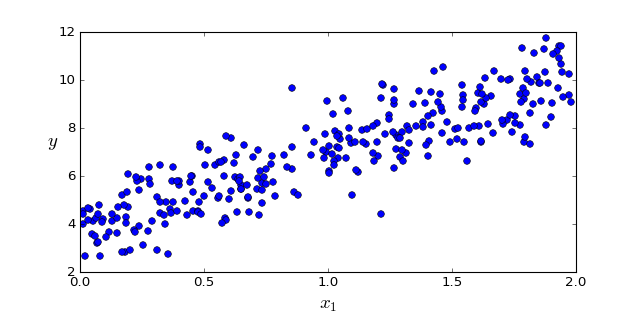

In [87]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
np.random.seed(42)
rcParams['axes.labelsize'] = 12

# create dataset
def create_dataset(m):
    X = 2 * np.random.rand(m, 1)
    y = 4 + 3 * X + np.random.randn(m, 1)
    return X, y
    
m = 300
X, y = create_dataset(m)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(X, y, "bo", ms=6)
ax.set_xlabel("$x_1$", fontsize=17)
ax.set_ylabel("$y$", fontsize=17, rotation=0)
fig.subplots_adjust(bottom=0.15)
plt.show()

We use the following function for plotting the learning curves:

In [76]:
# learning curve
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, ylims=(0, 2.5), fig=None, ax=None):
    """
    Creates a learning curves plot
    The model is trained using N=1,2,...,len(X) samples each time. 
    We then measure the prediction error on:
        - the training subset with N samples
        - the validation set
    Note that the training set size changes whereas 
    the validation set size is fixed.
    """
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        
        model.fit(X_train[:m], y_train[:m])         # fit
        
        y_train_pred = model.predict(X_train[:m])   # m samples at a time
        y_val_pred = model.predict(X_val)           # the whole validation set at a time
        
        train_errors.append(mse(y_train[:m], y_train_pred))
        val_errors.append(mse(y_val, y_val_pred))
    
    train_rmse = np.sqrt(train_errors)
    val_rmse = np.sqrt(val_errors)
    
    # plot
    #fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    ax.plot(train_rmse, "r", label="Train")
    ax.plot(val_rmse, "b", label="Validation")
    ax.legend(loc="upper right", fontsize=12)
    ax.set_xlabel("Training set size")
    ax.set_ylabel("RMSE")
    ax.set_ylim(ylims[0], ylims[1])
    fig.subplots_adjust(bottom=0.15)
    plt.show()

<IPython.core.display.Javascript object>


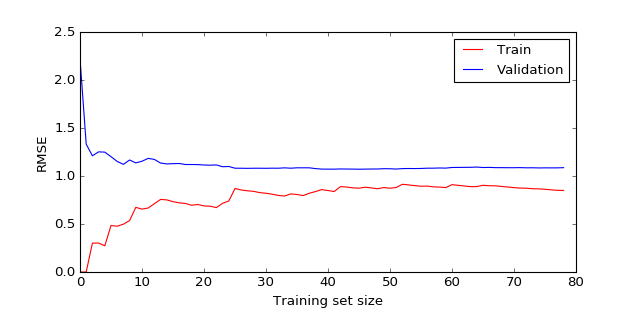

In [77]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

---

Let's look at the learning curves of the plain Linear Regression model. First, let's look at the performance on the training data (**red line**): when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes imposible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn't make the average error (i.e., RMSE) much better or worse.

Now, let's look at the performance of the model in the validation data. Whe the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is hown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

These learining curves are typical of an underfitting model. Both curves have reached a plateau; they are clode and fairly high.

**If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.**

[Geron] p. 128


<IPython.core.display.Javascript object>


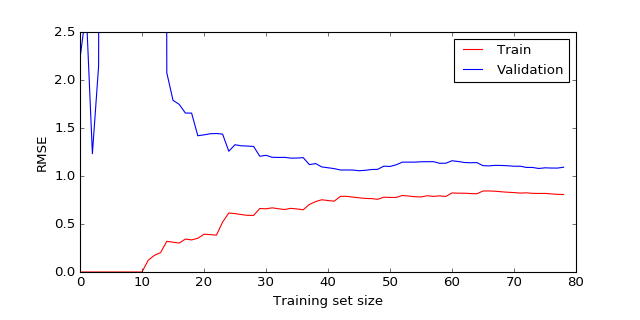

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y, (0, 2.5))

---

Now, let's look at the learning curves of a 10-th-degree polynomial model on the same data. These learning curves look a bit like the previous ones, but there are two very important differences:

- The error on the training data is much lower than with the Linear Regression model.
- **There is a gap between the curves**. This means that the model performs significantly better on the training data than on the validation data, which is the **hallmark of an overfitting model**. However, if you used a much larger training set, the two curves would continue to get closer.

**One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error**.

[Geron] p. 128

<IPython.core.display.Javascript object>


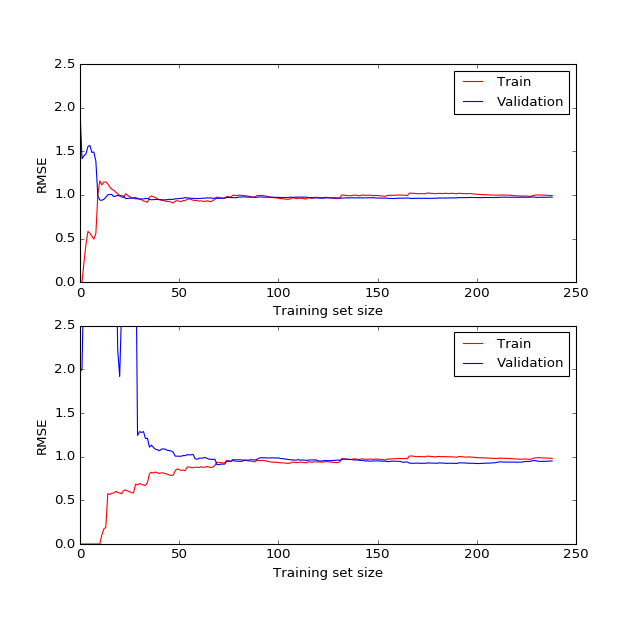

In [88]:
#fig, axes = plt.subplots(1, 2, figsize=(17, 4))
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax1, ax2 = axes[0], axes[1]

plot_learning_curves(lin_reg, X, y, (0, 2.5), fig, ax1)
plot_learning_curves(polynomial_regression, X, y, (0, 2.5), fig, ax2)

# Bias-variance tradeoff


----
We say that the model is too **biased** for the given data, or that is is **underfitting**. We say that the model has a too **high variance** for the given data, or that is is **overfitting**.


If we suffer from high bias, then adding more data does not help. Also, removing features surely will not help, as our model would have already been overly simplistic. The only possibilities we have in this case are to get more features, make the model more complex, or change the model.

If we suffer from high variance, that means that the model is too complex for the data. In this case, we can only try to get more data or decrease the complexity.

[Coelho] p. 108

----

# References

- [Geron] Hands-On Machine Learning with Scikit-Learn & TensorFlow. Aurélien Géron.
- [Jason] Better Deep Learning. Jason Brownlee.